In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [18]:
# amsterdam tree data
df_trees = pd.read_csv('data/bomen-stamgegevens-2024-03-12T09 06 04.036291.csv')
# amsterdam neighbourhood meta data, i.e. matching neighbourhood name with ID
df_buurt_meta = pd.read_csv('data/gebieden-buurten-2024-03-12T12 09 07.653588.csv')
# amsterdam sub-district meta data, to match each neighbourhood with its district
df_wijk_meta = pd.read_csv('data/gebieden_wijken.csv')


# standardise names of neighbourhood id column so we can merge on that column
buurt_id_column = 'buurt_id'
wijk_id_column = 'wijk_id'

# rename buurt id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Identificatie': buurt_id_column}
)
df_trees = df_trees.rename(
    columns={'Gbdbuurtid': buurt_id_column}
)

# rename wijk id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Ligtinwijkid': wijk_id_column}
)
df_wijk_meta = df_wijk_meta.rename(
    columns={'Identificatie': wijk_id_column}
)


In [19]:
# match each buurt (neighbourhood) with its associated wijk (sub-district)
df_buurt_simple = df_buurt_meta[[
    buurt_id_column, wijk_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_buurt_simple = df_buurt_simple.rename(
    columns={
        'Naam': 'Naam_buurt',
        'Code': 'Code_buurt',
        'Cbscode': 'Cbscode_buurt',
        'Geometrie': 'Geometrie_buurt'
    }
)

df_wijk_simple = df_wijk_meta[[
    wijk_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_wijk_simple = df_wijk_simple.rename(
    columns={
        'Naam': 'Naam_wijk',
        'Code': 'Code_wijk',
        'Cbscode': 'Cbscode_wijk',
        'Geometrie': 'Geometrie_wijk'
    }
)

df_location_data = pd.merge(df_buurt_simple, df_wijk_simple, on=wijk_id_column)

In [20]:
# functions for data cleaning
# return the proportion of nan each column in the data
def na_proportion(series: pd.Series):
    return series.isna().sum() / len(series)

# returns a dataframe without the columns that have higher proportion of na 
# than threshold. 
# default threshold: 40% of nan means removal
def stripped_threshold_na_columns(df: pd.DataFrame, threshold = 0.4):
    df_return = pd.DataFrame()
    for column in df.columns:
        if na_proportion(df[column]) < threshold:
            df_return[column] = df[column]
    return df_return

# returns the n most common values in a series (by default the 10 most common)
def most_common_n_values(series: pd.Series, n = 10):
    return series.value_counts()[:n].index.tolist()

def replace_less_than_n_values(series: pd.Series, n = 30, placeholder = np.nan):
    value_counts = series.value_counts()
    values_to_replace = value_counts[value_counts < n].index
    return series.replace(to_replace=values_to_replace, value=placeholder)


# return a series with its least common values converted to a different value
# by default, the string 'other'
def otherise(value, most_common_values, other, nan_replace):
    if value in most_common_values:
        return value
    if value is np.nan:
        return nan_replace
    return other
    

def otherise_less_common_values(
        series: pd.Series, 
        most_common_values, 
        other='other', 
        nan_replace = np.nan
    ):
    return series.apply(
        lambda value: otherise(value, most_common_values, other, nan_replace)
    )


In [21]:
# clean up tree data
# remove columns that have too many NaNs
df_trees = stripped_threshold_na_columns(df_trees)

# height
# we only have approximate measures for tree height :(
# Brute force normalising it to numbers to avoid using regex and preserve my sanity
# There are some severe limitations from applying a linear regression model
# to height that is calculated this way.
def extract_height_data(data):
    if data == 'a. tot 6 m.':
        return 3
    if data == 'b. 6 tot 9 m.':
        return 7.5
    if data == 'c. 9 tot 12 m.':
        return 10.5
    if data == 'd. 12 tot 15 m.':
        return 13.5
    if data == 'e. 15 tot 18 m.':
        return 16.5
    if data == 'f. 18 tot 24 m.':
        return 21
    if data == 'g. 24 m. en hoger':
        return 24
    # if not any of the above return nan
    return np.nan

df_trees['tree_height'] = df_trees['Boomhoogteklasseactueel'].apply(
    lambda x: extract_height_data(x)
)


'''
Index([
       'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
       'Soortnaamtop', 'tree_height'],
      dtype='object')
'''



"\nIndex([\n       'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',\n       'Soortnaamtop', 'tree_height'],\n      dtype='object')\n"

Text(0, 0.5, 'Frequency')

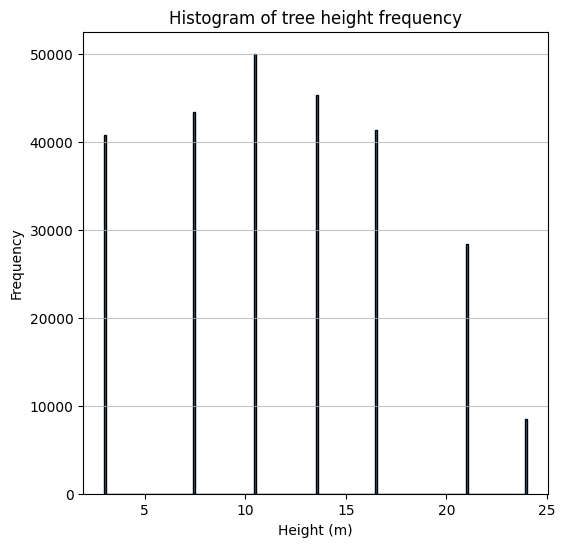

In [22]:
# visualise tree height distribution
plt.figure(figsize=(6, 6))
plt.hist(df_trees['tree_height'], bins=200, edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title("Histogram of tree height frequency")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")


In [23]:
# tree administrator ('Typebeheerderplus')
# categorical
print(f'proportion of nan for admin: {na_proportion(df_trees['Typebeheerderplus'])}')
print(df_trees['Typebeheerderplus'].value_counts())
most_common_tree_admins = most_common_n_values(df_trees['Typebeheerderplus'])
df_trees['tree_admin'] = otherise_less_common_values(
    df_trees['Typebeheerderplus'], most_common_tree_admins
)

proportion of nan for admin: 0.0013418888915997756
Typebeheerderplus
R&E_VOR_Bomen                      256142
SOC_S&B_Sport                       10248
R&E_VOR_EPR                          3422
Amsterdamse Bos                      3364
Begraafplaats De Nieuwe Ooster       2905
Recreatieschap Noord-Holland         2608
Gemeente Amsterdam, rve Sport        1698
Volkstuinpark                        1009
RVE Spieringhorn Sportpark           1003
Gemeentelijk Vastgoed                 818
Begraafplaats De Nieuwe Noorder       754
Amsterdamse bos - eigen dienst        635
Overig niet natuurlijk persoon        353
Rijkswaterstaat                       259
Schooltuinen                          251
Natuurlijk persoon                    235
Woningcorporatie                      222
R&E_VOR_Groen                         173
Toevoeging                            113
RVE Spieringpark                       64
Buitenaccommodaties en vastgoed        46
Begraafplaats Zorgvlied                41
Stichti

In [24]:
print(df_trees['tree_admin'].value_counts())

tree_admin
R&E_VOR_Bomen                     256142
SOC_S&B_Sport                      10248
R&E_VOR_EPR                         3422
Amsterdamse Bos                     3364
other                               3307
Begraafplaats De Nieuwe Ooster      2905
Recreatieschap Noord-Holland        2608
Gemeente Amsterdam, rve Sport       1698
Volkstuinpark                       1009
RVE Spieringhorn Sportpark          1003
Gemeentelijk Vastgoed                818
Name: count, dtype: int64


In [25]:
# municipality that owns the trees
print(
    f'proportion of nan for municipality: {na_proportion(df_trees['Typeeigenaarplus'])}'
)
print(df_trees['Typeeigenaarplus'].value_counts())
# the overwhelming majority of trees are owned by amsterdam.
# let's have values for just "amsterdam" and "not amsterdam"
amsterdam_ownership = ['Gemeente Amsterdam']
df_trees['tree_municipality'] = otherise_less_common_values(
    df_trees['Typeeigenaarplus'], amsterdam_ownership
)

proportion of nan for municipality: 0.07132575137064365


Typeeigenaarplus
Gemeente Amsterdam       256869
Gemeente Weesp             6275
Gemeentelijk Vastgoed      1455
Gemeente Ouder-Amstel      1257
Gemeente Diemen             331
Woningcorporatie            181
Artis                        33
Natuurlijk persoon           21
Gemeente Amstelveen          14
Rijksmuseum                   8
Amsterdamse Bos               1
Name: count, dtype: int64


In [26]:
df_trees['tree_municipality'].value_counts()

tree_municipality
Gemeente Amsterdam    256869
other                   9576
Name: count, dtype: int64

In [27]:
# tree planting year
print(
    f'proportion of nan for planting year: {na_proportion(df_trees['Jaarvanaanleg'])}'
)
# not many nans :)
print(df_trees['Jaarvanaanleg'].value_counts())
# lots of zeros :(
# Removing all the rows with nonsensical years
year_threshold = 1500 # respect for our elder trees
df_trees = df_trees[df_trees.Jaarvanaanleg > year_threshold]


proportion of nan for planting year: 0.0027883405539735596
Jaarvanaanleg
0.0       38452
1970.0    14792
1990.0    14134
1980.0    12423
1985.0    11789
          ...  
216.0         1
191.0         1
1894.0        1
200.0         1
1919.0        1
Name: count, Length: 166, dtype: int64


<Axes: xlabel='Jaarvanaanleg', ylabel='Count'>

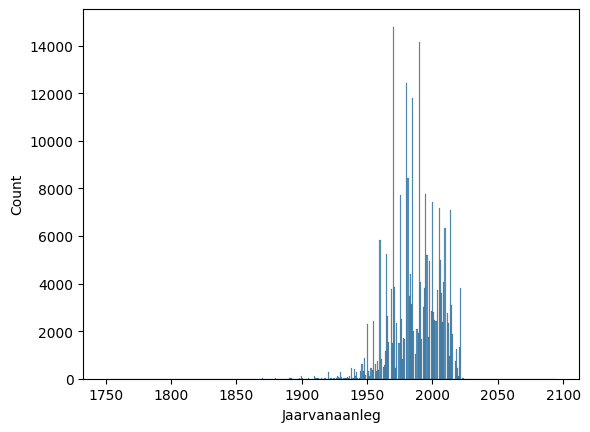

In [28]:
sns.histplot(df_trees['Jaarvanaanleg'])

In [29]:
# there are three columns for the species of the tree
# Soortnaam: specific latin name species
print(f'nan proportion Soortnaam: {na_proportion(df_trees['Soortnaam'])}')
print(df_trees['Soortnaam'].value_counts())
# Sortnaamkort/Sortnaamtop are for grouped species (they're the same)
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
print(df_trees['Soortnaamkort'].value_counts())
print(f'nan proportion Soortnaamtop: {na_proportion(df_trees['Soortnaamtop'])}')
print(df_trees['Soortnaamtop'].value_counts())

# let's choose both, even if they will by definition be highly correlated in some ways

nan proportion Soortnaam: 0.01198903259934664
Soortnaam
Platanus hispanica                   14378
Fraxinus excelsior                    8154
Quercus robur                         7597
Salix alba                            7597
Acer campestre                        6524
                                     ...  
Taxodium distichum 'Pevé Minaret'        1
Quercus rhysophylla 'Maya'               1
Malus domestica 'Melrose'                1
Aesculus cv.                             1
Wisteria sinesis                         1
Name: count, Length: 1475, dtype: int64
nan proportion Soortnaamkort: 0.01470261626615733
Soortnaamkort
Ulmus           29924
Tilia           24681
Acer            23814
Fraxinus        19116
Platanus        15114
                ...  
Berberis            1
Choisya             1
Corylopsis          1
Chimonanthus        1
Arbutus             1
Name: count, Length: 168, dtype: int64
nan proportion Soortnaamtop: 0.01470261626615733
Soortnaamtop
Iep (Ulmus)           29

In [30]:
# Soortnaam (exact species)
# How many species are there?
print(f'number of species: {df_trees['Soortnaam'].value_counts().shape}')
# proportion of nan?
print(f'nan proportion Soortnaam: {na_proportion(df_trees['Soortnaam'])}')
# let's remove trees which species there are too few of
species_threshold = 10
df_trees['Soortnaam'] = replace_less_than_n_values(
    df_trees['Soortnaam'],
    species_threshold
)
# how much did that remove?
print(f'number of species after removal: {df_trees['Soortnaam'].value_counts().shape}')
print(f'nan proportion Soortnaam after removal: {na_proportion(df_trees['Soortnaam'])}')


number of species: (1475,)
nan proportion Soortnaam: 0.01198903259934664
number of species after removal: (653,)
nan proportion Soortnaam after removal: 0.02026707801149235


In [35]:
# Soortnaamkort (species group)
# How many groups are there?
print(f'number of species groups: {df_trees['Soortnaamkort'].value_counts().shape}')
# proportion of nan?
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
# let's remove trees which species group there are too few of
gr_species_threshold = 10
df_trees['Soortnaamkort'] = replace_less_than_n_values(
    df_trees['Soortnaamkort'],
    gr_species_threshold
)
# how much did that remove?
print(f'number of species groups after removal: {df_trees['Soortnaamkort'].value_counts().shape}')
print(f'nan proportion Soortnaamkort after removal: {na_proportion(df_trees['Soortnaamkort'])}')



number of species groups: (168,)
nan proportion Soortnaamkort: 0.01470261626615733
number of species groups after removal: (94,)
nan proportion Soortnaamkort after removal: 0.015514268523640887


In [31]:
df = pd.merge(df_trees, df_location_data, on=buurt_id_column)
df.sample(10).head()

,Id,buurt_id,Geometrie,Typebeheerderplus,Boomhoogteklasseactueel,Typeeigenaarplus,Jaarvanaanleg,Soortnaam,Typeobject,Typesoortnaam,...,tree_municipality,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk
103026,1032781,3.630980e+12,SRID=28992;POINT (128693.02 484990.59),R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,2009.0,Platanus hispanica,Boom niet vrij uitgroeiend,Bomen,...,Gemeente Amsterdam,3630970000081,Havenkwartier IJburg,ML01,BU0363ML01,"SRID=28992;POLYGON ((129128.648 485371.33, 128...",IJburg-Zuid,ML,WK0363ML,"SRID=28992;POLYGON((129298.966 485048.564,1292..."
104682,1034507,3.630980e+12,SRID=28992;POINT (124412.31 485757.76),R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,2002.0,Prunus avium 'Plena',Boom niet vrij uitgroeiend,Bomen,...,Gemeente Amsterdam,3630970000076,Ambonpleinbuurt,MF03,BU0363MF03,"SRID=28992;POLYGON ((124520.07 486066.635, 124...",Indische Buurt-West,MF,WK0363MF,"SRID=28992;POLYGON((124507.705 486304.448,1245..."
228552,1276499,3.630980e+12,SRID=28992;POINT (131025.465546464 480320.3120...,R&E_VOR_Bomen,e. 15 tot 18 m.,Gemeente Weesp,1974.0,Aesculus hippocastanum 'Baumannii',Boom niet vrij uitgroeiend,Bomen,...,other,3630970000103,Hogewey-Midden,SC03,BU0363SC03,"SRID=28992;POLYGON ((130873.805 480764.04, 130...",Weesp-Noordwest,SC,WK0363SC,"SRID=28992;POLYGON((130752.865 481221.406,1306..."
60126,987314,3.630980e+12,SRID=28992;POINT (119934.77 484723.5),R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,2006.0,Ulmus 'Columella',Boom niet vrij uitgroeiend,Bomen,...,Gemeente Amsterdam,3630970000063,Minervabuurt-Noord,KJ02,BU0363KJ02,"SRID=28992;POLYGON ((120355.499 484857.456, 12...",Apollobuurt,KJ,WK0363KJ,"SRID=28992;POLYGON((120868.184 484624.849,1207..."
175007,1110837,3.630980e+12,SRID=28992;POINT (116015.83 484680.25),R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Amsterdam,1990.0,Betula ermanii cv.,Boom niet vrij uitgroeiend,Bomen,...,Gemeente Amsterdam,3630970000054,Nieuw-Sloten-Noordoost,FQ03,BU0363FQ03,"SRID=28992;POLYGON ((116435.107 485020.682, 11...",Sloten/Nieuw-Sloten,FQ,WK0363FQ,"SRID=28992;POLYGON((117331.655 484334.668,1170..."
